### 개선방향
- `04_04_FE.ipynb`에서 전처리를 완료한 데이터를 사용하여 LightGBM을 학습

# Module

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

%matplotlib inline

plt.style.use("seaborn-v0_8-white")

# Data

In [2]:
data_path = "./data/"

all_data = joblib.load(data_path + 'all_data2.joblib')
sub = pd.read_csv(data_path + 'sample_submission.csv')
all_data.shape

(8812244, 62)

# Model

## prepare

In [3]:
x_train = all_data[all_data['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis=1)

x_val = all_data[all_data['date_block_num'] == 33]
x_val = x_val.drop(['item_cnt_month'], axis=1)

x_test = all_data[all_data['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis=1)

y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
y_val = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

x_all = pd.concat([x_train, x_val])
y_all = pd.concat([y_train, y_val])

x_sample = all_data[(all_data['date_block_num'] > 12)&(all_data['date_block_num'] < 33)]
x_sample = x_sample.drop(['item_cnt_month'], axis=1)
y_sample = all_data[(all_data['date_block_num'] > 12)&(all_data['date_block_num'] < 33)]['item_cnt_month']

del all_data

In [4]:
x_sample.shape, y_sample.shape

((4755902, 61), (4755902,))

In [5]:
cat_features = ['shop_id', 'type', 'subtype', 'shop_type', 'shop_category', 'item_category_id', 'city', 'month']

dtrain = lgb.Dataset(x_sample, y_sample, categorical_feature=cat_features)
dval = lgb.Dataset(x_val, y_val, categorical_feature=cat_features, reference=dtrain)

- 하이퍼 파라미터 최적화 과정에서 일부 데이터만 활용

## optuna

In [6]:
%%time
fixed_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1,
    'feature_pre_filter': False,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
}

def objective_lgbm(trial):
    params = {
        **fixed_params,
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 40),
    }
    
    pruning_callback = LightGBMPruningCallback(trial, 'rmse', valid_name='eval')
    
    lgb_model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=1500,
        valid_sets=[dval],
        valid_names=['eval'],
        callbacks=[
            early_stopping(stopping_rounds=300, verbose=False),
            log_evaluation(period=0),
            pruning_callback
        ]
    )
    
    trial.set_user_attr("best_iter", lgb_model.best_iteration)
    
    preds = lgb_model.predict(x_val, num_iteration=lgb_model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse 


sampler = TPESampler(seed=2025)
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30, show_progress_bar=True)

[I 2025-12-03 15:28:07,084] A new study created in memory with name: no-name-86221229-b069-46f3-b0b0-c49c1afe32db


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-03 15:32:41,479] Trial 0 finished with value: 0.793385255918958 and parameters: {'num_leaves': 154, 'learning_rate': 0.03862083925763863, 'feature_fraction': 0.9663028199432513, 'bagging_fraction': 0.7227840820237976, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 0 with value: 0.793385255918958.
[I 2025-12-03 15:37:29,850] Trial 1 finished with value: 0.803209862625581 and parameters: {'num_leaves': 363, 'learning_rate': 0.015544864538066484, 'feature_fraction': 0.9821192096250286, 'bagging_fraction': 0.90049223743472, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 0 with value: 0.793385255918958.
[I 2025-12-03 15:39:18,049] Trial 2 finished with value: 0.7844429585688477 and parameters: {'num_leaves': 116, 'learning_rate': 0.02940545313845548, 'feature_fraction': 0.5015855583776472, 'bagging_fraction': 0.6464046960247385, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 2 with value: 0.7844429585688477.
[I 2025-12-03 15:44:30,989] Trial 3 

In [7]:
print(f'Total Trials : {len(study_lgbm.trials)}')
print(f'Best Trial : {study_lgbm.best_trial.number}')
print(f'Best Iteration : {study_lgbm.best_trial.user_attrs['best_iter']}')
print(f'Best Score : {study_lgbm.best_value:.5f}')
print('=='*20,'Best Parameters', '=='*20)
for key, value in study_lgbm.best_params.items():
    print(f'{key} : {value}')

Total Trials : 30
Best Trial : 27
Best Iteration : 124
Best Score : 0.78116
======================================== Best Parameters ========================================
num_leaves : 196
learning_rate : 0.04347052814031801
feature_fraction : 0.6845724966545648
bagging_fraction : 0.5422092608042339
bagging_freq : 6
min_child_samples : 30


/tmp/ipykernel_61764/1748665859.py:1: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

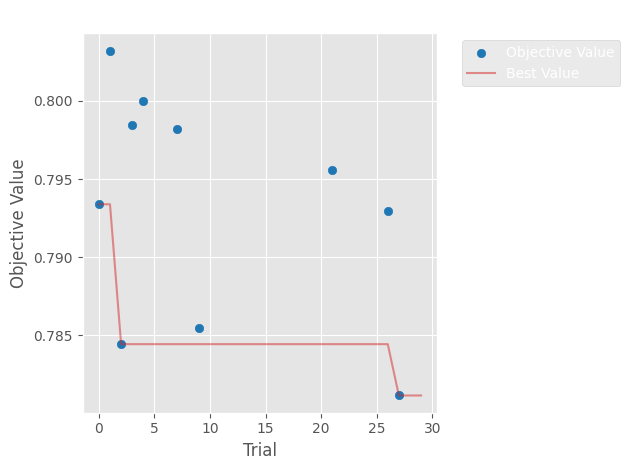

In [8]:
plot_optimization_history(study_lgbm)

/tmp/ipykernel_61764/3004270277.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_lgbm)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

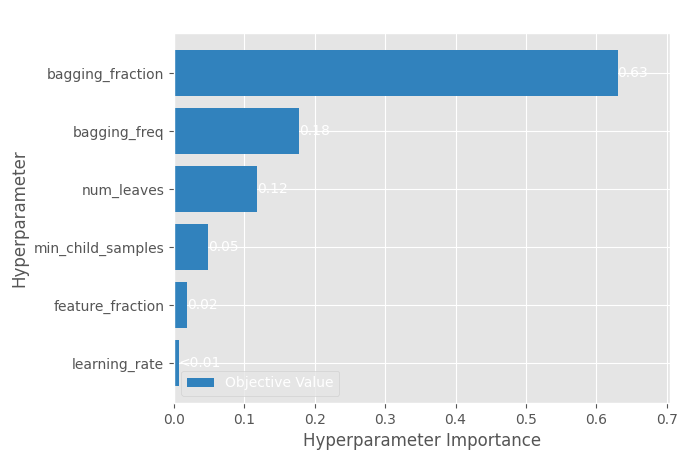

In [9]:
plot_param_importances(study_lgbm)

## train

In [10]:
best_params = study_lgbm.best_params
best_params.update(fixed_params)
best_iter = study_lgbm.best_trial.user_attrs['best_iter']

In [11]:
dtrain_all = lgb.Dataset(x_all, y_all, categorical_feature=cat_features)
final_iter = int(best_iter * 1.3)

In [12]:
%%time

final_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain_all,
    num_boost_round=final_iter,
    valid_sets=[dtrain_all],
    callbacks=[
        log_evaluation(period=100)
    ]
)

[100]	training's rmse: 0.817469
CPU times: user 10min 14s, sys: 6.57 s, total: 10min 21s
Wall time: 2min 59s


In [14]:
final_lgbm_model.save_model(data_path + '05_04_lgbm_model.txt')

In [2]:
final_lgbm_model = lgb.Booster(model_file='./data/05_04_lgbm_model.txt')

/tmp/ipykernel_5833/2238109636.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')


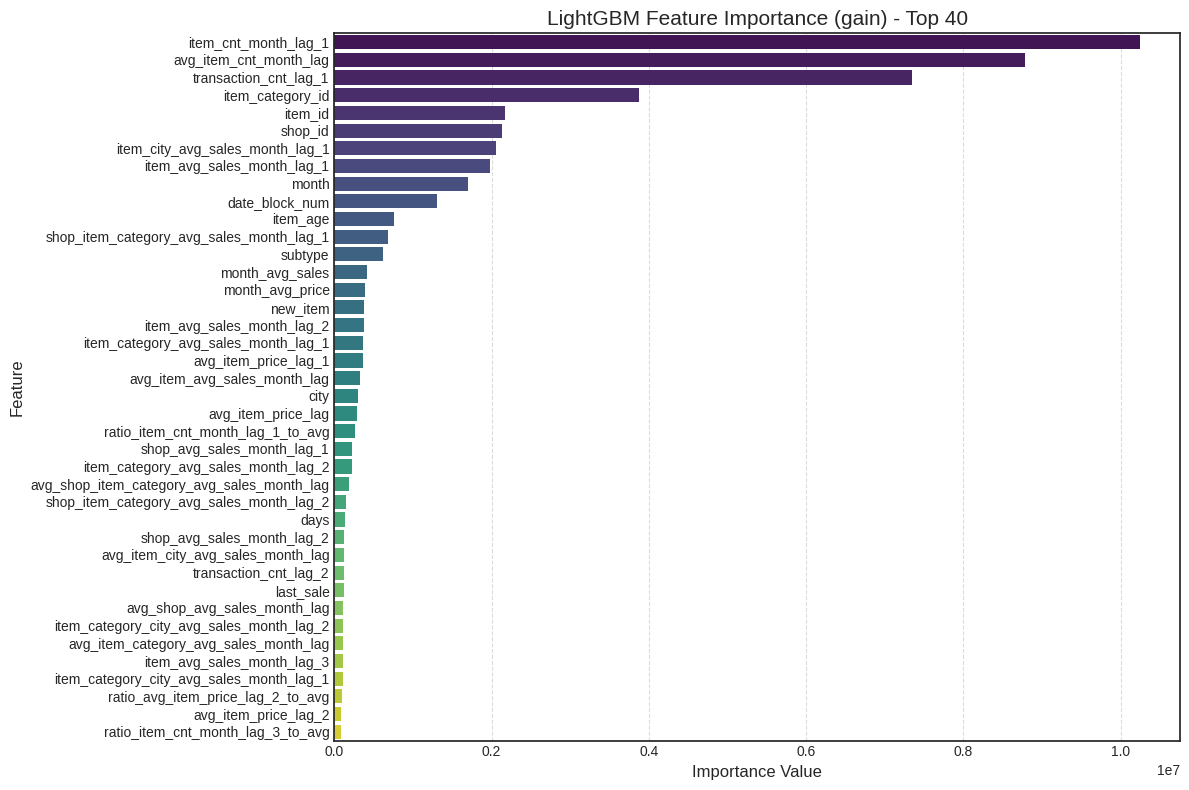

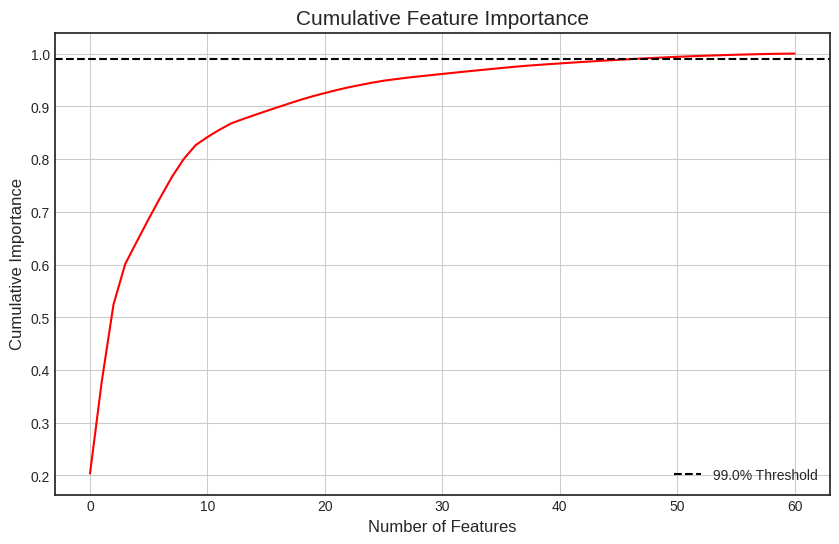

[GAIN] 분석 결과:
- 전체 피처 수: 61
- 99.0% 중요도를 설명하는 피처 수: 48
- 제거 추천 피처 수: 13
drop_cols :  ['type', 'avg_item_price_lag_3', 'delta_item_cnt_month_lag_1', 'delta_avg_item_price_lag_2', 'shop_avg_sales_month_lag_3', 'ratio_avg_item_price_lag_3_to_avg', 'item_city_avg_sales_month_lag_3', 'item_category_city_avg_sales_month_lag_3', 'ratio_item_cnt_month_lag_2_to_avg', 'shop_type', 'transaction_cnt_lag_3', 'delta_item_cnt_month_lag_2', 'shop_category']


In [3]:
def analyze_and_filter_features(model, importance_type='gain', cum_threshold=0.99):
    if isinstance(model, lgb.Booster):
        importance = model.feature_importance(importance_type=importance_type)
        feature_names = model.feature_name()
    else:
        importance = model.booster_.feature_importance(importance_type=importance_type)
        feature_names = model.booster_.feature_name()
        
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    feature_imp['normalized_importance'] = feature_imp['importance'] / feature_imp['importance'].sum()
    feature_imp['cumulative_importance'] = feature_imp['normalized_importance'].cumsum()
    

    plt.figure(figsize=(12, 8))    
    sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')
    plt.title(f'LightGBM Feature Importance ({importance_type}) - Top 40', fontsize=15)
    plt.xlabel('Importance Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_imp.index, feature_imp['cumulative_importance'], 'r-')
    plt.axhline(y=cum_threshold, color='k', linestyle='--', label=f'{cum_threshold*100}% Threshold')
    plt.title('Cumulative Feature Importance', fontsize=15)
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Cumulative Importance', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    cutoff_index = feature_imp[feature_imp['cumulative_importance'] > cum_threshold].index[0]
    selected_features = feature_imp.loc[:cutoff_index, 'feature'].tolist()
    removed_features = feature_imp.loc[cutoff_index+1:, 'feature'].tolist()
    
    print(f"[{importance_type.upper()}] 분석 결과:")
    print(f"- 전체 피처 수: {len(feature_imp)}")
    print(f"- {cum_threshold*100}% 중요도를 설명하는 피처 수: {len(selected_features)}")
    print(f"- 제거 추천 피처 수: {len(removed_features)}")
    
    return feature_imp, selected_features, removed_features

df_imp, keep_cols, drop_cols = analyze_and_filter_features(final_lgbm_model, importance_type='gain', cum_threshold=0.99)
print('drop_cols : ', drop_cols)

- 파생변수인 `type`, `shop_type`, `shop_category` 삭제
- lag_3 이상의 변수들의 중요도가 낮게 나타남 -> lag period를 [1,2]로 단축
- 변수 제거 후 `rmse` 변화 관찰

## prediction

In [15]:
final_lgbm_model = lgb.Booster(model_file='./data/05_04_lgbm_model.txt')

In [16]:
predictions = final_lgbm_model.predict(x_test).clip(0, 20)
sub['item_cnt_month'] = predictions
sub.head()

,ID,item_cnt_month
0,0,0.416237
1,1,0.142819
2,2,0.865379
3,3,0.370697
4,4,1.717075


In [17]:
print(pd.Series(predictions).describe())

count    214200.000000
mean          0.291503
std           0.838294
min           0.000000
25%           0.026765
50%           0.078043
75%           0.248520
max          20.000000
dtype: float64


In [18]:
sub.to_csv(data_path + '05_04_submssion_lgbm_model.csv', index=False)

In [19]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/05_04_submssion_lgbm_model.csv" -m "05_04_submssion_lgbm_model_v3"

100%|██████████████████████████████████████| 5.34M/5.34M [00:00<00:00, 12.2MB/s]
Successfully submitted to Predict Future Sales

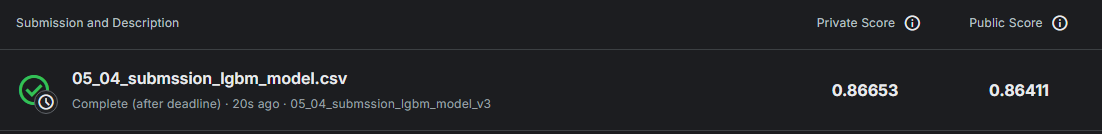